### Comparing Aggregate Models for Regression

This try-it focuses on utilizing ensemble models in a regression setting.  Much like you have used individual classification estimators to form an ensemble of estimators -- here your goal is to explore ensembles for regression models.  As with your earlier assignment, you will use scikitlearn to carry out the ensembles using the `VotingRegressor`.   


#### Dataset and Task

Below, a dataset containing census information on individuals and their hourly wage is loaded using the `fetch_openml` function.  OpenML is another repository for datasets [here](https://www.openml.org/).  Your task is to use ensemble methods to explore predicting the `wage` column of the data.  Your ensemble should at the very least consider the following models:

- `LinearRegression` -- perhaps you even want the `TransformedTargetRegressor` here.
- `KNeighborsRegressor`
- `DecisionTreeRegressor`
- `Ridge`
- `SVR`

Tune the `VotingRegressor` to try to optimize the prediction performance and determine if the wisdom of the crowd performed better in this setting than any of the individual models themselves.  Report back on your findings and discuss the interpretability of your findings.  Is there a way to determine what features mattered in predicting wages?

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
survey = fetch_openml(data_id=534, as_frame=True).frame

In [3]:
survey.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [4]:
survey.isnull().sum()

EDUCATION     0
SOUTH         0
SEX           0
EXPERIENCE    0
UNION         0
WAGE          0
AGE           0
RACE          0
OCCUPATION    0
SECTOR        0
MARR          0
dtype: int64

In [5]:
survey_encoded = pd.get_dummies(survey, drop_first=True)

In [7]:
X = survey_encoded.drop('WAGE', axis=1)
y = survey_encoded['WAGE']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Display the first few rows of the processed training data
X_train.head(), y_train.head()

(     EDUCATION  EXPERIENCE  AGE  SOUTH_yes  SEX_male  UNION_not_member  \
 489         16          16   38      False     False              True   
 299         12          19   37      False      True              True   
 526         15          10   31      False      True              True   
 513         12          39   57      False      True             False   
 312         13           0   19       True     False              True   
 
      RACE_Other  RACE_White  OCCUPATION_Management  OCCUPATION_Other  \
 489       False        True                  False             False   
 299       False        True                  False             False   
 526       False        True                  False             False   
 513       False        True                  False             False   
 312       False        True                  False             False   
 
      OCCUPATION_Professional  OCCUPATION_Sales  OCCUPATION_Service  \
 489                     True        

In [39]:
# Instantiate individual regression models
lr = LinearRegression()
ridge = Ridge()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
svr = SVR()

In [40]:
ttr = TransformedTargetRegressor(regressor=lr, transformer=StandardScaler())

In [41]:
# Function to train and evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Evaluate individual models
models = {
    'LinearRegression': lr,
    'Ridge': ridge,
    'KNeighborsRegressor': knn,
    'DecisionTreeRegressor': dt,
    'SVR': svr,
    'TransformedTargetRegressor': ttr
}

In [42]:
results = {}
for name, model in models.items():
    mse, r2 = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {'MSE': mse, 'R2': r2}

In [43]:
# Combine models using VotingRegressor
voting_regressor = VotingRegressor(estimators=[
    ('lr', ttr),
    ('ridge', ridge),
    ('knn', knn),
    ('dt', dt),
    ('svr', svr)
])

In [44]:
ensemble_mse, ensemble_r2 = evaluate_model(voting_regressor, X_train, y_train, X_test, y_test)
results['VotingRegressor'] = {'MSE': ensemble_mse, 'R2': ensemble_r2}

In [45]:
results_df = pd.DataFrame(results).T
print(results_df)

                                  MSE        R2
LinearRegression            19.502597  0.388221
Ridge                       19.497452  0.388383
KNeighborsRegressor         25.796012  0.190802
DecisionTreeRegressor       57.733420 -0.811045
SVR                         27.528006  0.136471
TransformedTargetRegressor  19.502597  0.388221
VotingRegressor             23.133314  0.274329


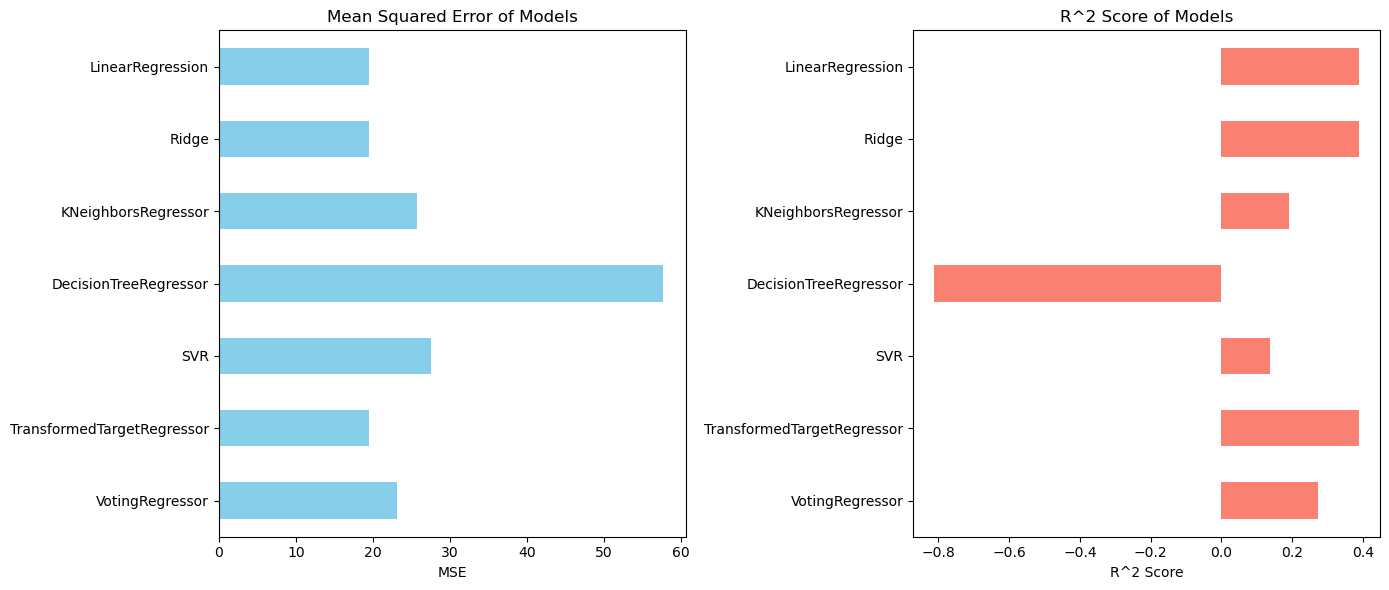

In [46]:
# Plot the results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot Mean Squared Error
results_df['MSE'].plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Mean Squared Error of Models')
axes[0].set_xlabel('MSE')
axes[0].invert_yaxis()

# Plot R^2 Score
results_df['R2'].plot(kind='barh', ax=axes[1], color='salmon')
axes[1].set_title('R^2 Score of Models')
axes[1].set_xlabel('R^2 Score')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

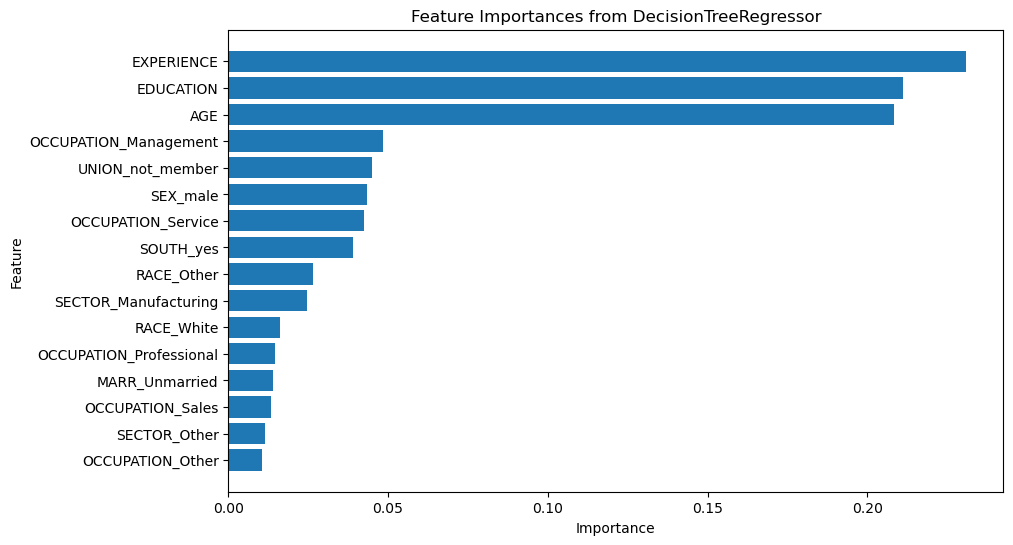

In [47]:
# Feature importances from DecisionTreeRegressor
feature_importances = dt.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DecisionTreeRegressor')
plt.gca().invert_yaxis()
plt.show()